# 03 — Data Pipeline and Scalability Notes

## 1. Objective and Modeling Strategy

The objective of this notebook is to develop predictive models that identify customers at high risk of churn and to translate model results into actionable business insights.

Specifically, this analysis aims to:
- Predict customer churn using historical customer attributes and service information
- Compare an interpretable baseline model with a more flexible tree-based model
- Identify key drivers of churn through model interpretation
- Provide data-driven recommendations for customer retention strategies

We begin with a Logistic Regression model as a transparent baseline, followed by a Random Forest model to capture non-linear patterns and interactions.

## 2.Data Preparation for Modeling

In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [4]:
df = pd.read_csv("data/telco_customer_churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df["Churn"] = df["Churn"].map({"No": 0, "Yes": 1})
df["Churn"].value_counts(normalize=True)

Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64

The target variable is moderately imbalanced, with approximately 26% churned customers.

In [7]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Drop rows with missing TotalCharges
df = df.dropna()

In [8]:
df = df.drop(columns=["customerID"])

In [9]:
df_encoded = pd.get_dummies(df, drop_first=True)
df_encoded.shape

(7032, 31)

In [10]:
X = df_encoded.drop("Churn", axis=1)
y = df_encoded["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

In [11]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 3.Baseline Model: Logistic Regression

### 3.1 Train Logistic Regression Model

In [14]:
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)

log_reg.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

### 3.2 Model Evaluation — Classification Metrics

In [16]:
y_pred = log_reg.predict(X_test_scaled)
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1291
           1       0.50      0.80      0.61       467

    accuracy                           0.73      1758
   macro avg       0.70      0.75      0.70      1758
weighted avg       0.80      0.73      0.75      1758



### 3.3 ROC-AUC Score

In [18]:
roc_auc = roc_auc_score(y_test, y_prob)
roc_auc

0.8398474366268202

### 3.4 Confusion Matrix

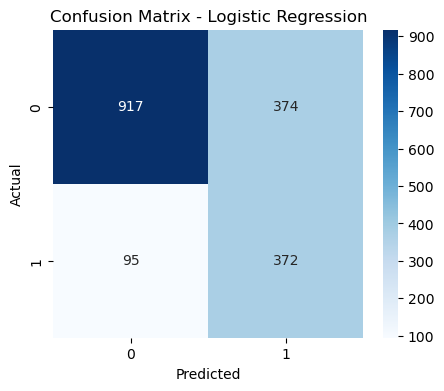

In [20]:
cm = confusion_matrix(y_test, y_pred)
cm
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

### 3.5 Interpretation — Coefficients Matter

In [22]:
coef_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": log_reg.coef_[0]
})

coef_df["abs_coef"] = coef_df["Coefficient"].abs()
coef_df = coef_df.sort_values("abs_coef", ascending=False)

coef_df.head(10)

,Feature,Coefficient,abs_coef
1,tenure,-1.240344,1.240344
2,MonthlyCharges,-1.025748,1.025748
10,InternetService_Fiber optic,0.798876,0.798876
25,Contract_Two year,-0.622872,0.622872
3,TotalCharges,0.603837,0.603837
24,Contract_One year,-0.295523,0.295523
21,StreamingTV_Yes,0.280238,0.280238
23,StreamingMovies_Yes,0.269867,0.269867
9,MultipleLines_Yes,0.205765,0.205765
28,PaymentMethod_Electronic check,0.178502,0.178502


### 3.6 Business Interpretation

The Logistic Regression model reveals several clear drivers of customer churn:

- **Tenure** is the strongest retention factor. Customers with longer tenure are significantly less likely to churn, highlighting the importance of early-stage retention efforts.
- **Higher Monthly Charges** are associated with increased churn risk, suggesting price sensitivity when perceived value is insufficient.
- **Contract Type** matters. Month-to-month customers churn far more than those on one- or two-year contracts, making contract migration a powerful retention lever.
- **Service mix effects** (e.g., Fiber Optic, Streaming services) indicate that premium services alone do not guarantee loyalty without adequate value and support.
- **Payment behavior** (Electronic Check) signals higher churn risk and can serve as an early behavioral indicator.

**Business takeaway:**  
Churn is primarily driven by **customer lifecycle stage, pricing pressure, and contract structure**. Retention strategies should prioritize early-tenure customers, promote long-term contracts, and target high-charge customers with value-based offers.

In [25]:
# ----------------------------------------
# Reusable function: build retention playbook for one customer
# ----------------------------------------

def build_retention_playbook(model, X_row, feature_names, top_n=5):
    """
    Generate interpretable churn drivers + business actions
    for a single customer.
    """

    # Ensure 1D array
    X_row = X_row.flatten()

    # Model coefficients
    coefs = model.coef_[0]

    # Contribution = coef * feature value
    contributions = coefs * X_row

    drivers = pd.DataFrame({
        "feature": feature_names,
        "contribution": contributions
    })

    # Keep only positive churn drivers
    drivers = drivers.sort_values(
        by="contribution", ascending=False
    ).head(top_n)

    # Map to business language
    FEATURE_TO_BUSINESS = {
        "tenure": "Short customer tenure",
        "MonthlyCharges": "High monthly charges",
        "Contract_Month-to-month": "Month-to-month contract",
        "Contract_One year": "Contract length factor",
        "Contract_Two year": "Contract length factor",
        "InternetService_Fiber optic": "Fiber optic service subscription",
        "PaymentMethod_Electronic check": "Electronic check payment method",
        "MultipleLines_Yes": "Multiple phone lines (service usage factor)",
    }

    drivers["business_driver"] = drivers["feature"].map(
        FEATURE_TO_BUSINESS
    ).fillna("Other service / pricing factor")

    drivers["direction"] = "↑ increases churn risk"

    # Business rationale + actions
    rationale_map = {
        "Short customer tenure":
            "Early-stage customers are more fragile and churn before habits form.",
        "High monthly charges":
            "Customers may feel pricing outweighs perceived value.",
        "Month-to-month contract":
            "Lack of commitment lowers switching costs.",
        "Contract length factor":
            "Commitment structure influences churn resilience.",
        "Fiber optic service subscription":
            "Premium services increase expectations around quality and support.",
        "Electronic check payment method":
            "Payment friction correlates with higher churn.",
        "Multiple phone lines (service usage factor)":
            "Service complexity increases support burden."
    }

    action_map = {
        "Short customer tenure":
            "- Trigger onboarding & early engagement journey\n- Proactive check-in within first 60 days",
        "High monthly charges":
            "- Offer targeted discount or value bundle\n- Reinforce value messaging",
        "Month-to-month contract":
            "- Incentivize 1–2 year contract migration",
        "Contract length factor":
            "- Validate plan satisfaction\n- Promote loyalty incentives",
        "Fiber optic service subscription":
            "- Proactive QoS monitoring\n- Priority tech support outreach",
        "Electronic check payment method":
            "- Encourage auto-pay / card payment incentives",
        "Multiple phone lines (service usage factor)":
            "- Offer multi-line bundle discount\n- Simplify billing"
    }

    drivers["business_rationale"] = drivers["business_driver"].map(rationale_map)
    drivers["recommended_actions"] = drivers["business_driver"].map(action_map)

    return drivers.reset_index(drop=True)

## 4. Model Interpretability: Key Churn Drivers

In [27]:
# 4.1 Helper function: compute top churn drivers for one sample
def get_top_churn_drivers(model, X_row, feature_names, top_n=5):
    coefs = model.coef_[0]
    contributions = coefs * X_row

    driver_df = pd.DataFrame({
        "feature": feature_names,
        "contribution": contributions
    }).sort_values(
        by="contribution", ascending=False
    )

    return driver_df.head(top_n)


# 4.2 Business mapping dictionary
FEATURE_TO_BUSINESS = {
    "tenure": "Short customer tenure",
    "MonthlyCharges": "High monthly charges",
    "Contract_Month-to-month": "Month-to-month contract",
    "PaymentMethod_Electronic check": "Electronic check payment method",
    "InternetService_Fiber optic": "Fiber optic service subscription"
}

FEATURE_TO_BUSINESS.update({
    "Contract_Two year": "Contract length factor",
    "Contract_One year": "Contract length factor",
    "MultipleLines_Yes": "Multiple phone lines (service usage factor)"
})


# 4.3 Pick one churned customer sample from test set
churned_idx = y_test[y_test == 1].index[0]

X_sample = X_test_scaled[list(y_test.index).index(churned_idx)]


# 4.4 Compute top churn drivers
drivers = get_top_churn_drivers(
    log_reg,
    X_sample,
    X_train.columns,
    top_n=5
)

# 4.5 Map to business explanation + direction
drivers["business_driver"] = drivers["feature"].map(FEATURE_TO_BUSINESS).fillna("Other service / pricing factor")
drivers["direction"] = drivers["contribution"].apply(
    lambda v: "↑ increases churn risk" if v > 0 else "↓ decreases churn risk"
)

drivers

,feature,contribution,business_driver,direction
1,tenure,1.491261,Short customer tenure,↑ increases churn risk
10,InternetService_Fiber optic,0.900061,Fiber optic service subscription,↑ increases churn risk
25,Contract_Two year,0.352069,Contract length factor,↑ increases churn risk
9,MultipleLines_Yes,0.240310,Multiple phone lines (service usage factor),↑ increases churn risk
24,Contract_One year,0.151709,Contract length factor,↑ increases churn risk


In [28]:
# -----------------------------
# FIX: Define feature_names for Step 5 / Step 6
# -----------------------------
# X_train_scaled / X_test_scaled were created from X_train (one-hot encoded columns),
# so feature_names must align with X_train columns (NOT the raw df columns).

feature_names = list(X_train.columns)

# Quick sanity check (optional)
assert X_train_scaled.shape[1] == len(feature_names), \
    f"Mismatch: X_train_scaled has {X_train_scaled.shape[1]} features but feature_names has {len(feature_names)}"
print("feature_names is ready. Total features:", len(feature_names))

feature_names is ready. Total features: 30


## 5 From Drivers → Retention Actions

In [30]:
drivers_tbl = None
for _name in ["drivers_df", "drivers"]:
    if _name in globals():
        drivers_tbl = globals()[_name].copy()
        break

if drivers_tbl is None:
    raise NameError("Cannot find `drivers_df` or `drivers`. Please run Step 4 first to create the drivers table.")

# Ensure required columns exist
required_cols = {"feature", "business_driver", "direction"}
missing = required_cols - set(drivers_tbl.columns)
if missing:
    raise ValueError(f"Drivers table is missing columns: {missing}. Expected columns: {required_cols}")

# ---- 5.1 Map business drivers to recommended retention actions ----
DRIVER_TO_ACTION = {
    "Short customer tenure": [
        "Trigger an onboarding/activation play (first 30–90 days).",
        "Offer a welcome bundle + proactive check-in (email/SMS).",
        "Monitor early support tickets and intervene quickly."
    ],
    "High monthly charges": [
        "Run a price-value review: offer a targeted discount or bundle.",
        "Provide a value recap (usage insights, plan fit) to reduce price shock.",
        "Test a downgrade-safe plan option (retain revenue vs churn)."
    ],
    "Month-to-month contract": [
        "Offer contract migration incentives (1-year/2-year upgrade).",
        "Promote loyalty benefits (price lock, free add-ons).",
        "Use churn-risk-triggered outreach before renewal cycle."
    ],
    "Electronic check payment method": [
        "Nudge to autopay / credit card with a small incentive.",
        "Send payment success confirmation + reduce friction in billing UX.",
        "Flag as behavioral risk signal for retention outreach."
    ],
    "Fiber optic service subscription": [
        "Proactive QoS/support outreach (latency, outages, router setup).",
        "Offer tech support add-on trial for high-risk customers.",
        "Ensure perceived value: streaming bundle or speed optimization tips."
    ],
    "Contract length factor": [
        "Validate customer’s plan satisfaction and improve perceived value.",
        "If eligible, promote price-lock renewal or contract extension benefits."
    ],
    "Multiple phone lines (service usage factor)": [
        "Offer multi-line discount / family bundle optimization.",
        "Check service issues across lines; provide proactive support."
    ],
    "Other service / pricing factor": [
        "Run a quick plan-fit review and recommend best plan option.",
        "Offer targeted support or add-on trial based on usage."
    ],
}

def _pick_actions(driver: str, max_actions: int = 2) -> str:
    actions = DRIVER_TO_ACTION.get(driver, [
        "Run a targeted retention outreach based on this risk factor.",
        "Test an offer/experience improvement and measure churn impact."
    ])
    return " ".join([f"- {a}" for a in actions[:max_actions]])

drivers_tbl["recommended_actions"] = drivers_tbl["business_driver"].apply(lambda d: _pick_actions(d, max_actions=2))

# ---- 5.2 Add a short "why this matters" note per driver (consultant style) ----
DRIVER_TO_WHYS = {
    "Short customer tenure": "Early-stage customers are more fragile and churn before forming habits.",
    "High monthly charges": "Customers churn when price exceeds perceived value.",
    "Month-to-month contract": "Low commitment increases sensitivity to alternatives and short-term issues.",
    "Electronic check payment method": "Payment friction correlates with weaker engagement and higher churn.",
    "Fiber optic service subscription": "Premium services can backfire if reliability/support is not strong.",
    "Contract length factor": "Commitment structure influences churn resilience.",
    "Multiple phone lines (service usage factor)": "More lines increase service complexity and support needs.",
    "Other service / pricing factor": "These factors may reflect plan mismatch or feature dissatisfaction."
}
drivers_tbl["business_rationale"] = drivers_tbl["business_driver"].map(DRIVER_TO_WHYS).fillna(
    "This factor may indicate a segment-specific retention opportunity."
)

# ---- 5.3 Build a final "Retention Playbook" table ----
playbook_cols = ["business_driver", "direction", "business_rationale", "recommended_actions"]
playbook = drivers_tbl[playbook_cols].copy()

# Optional: remove duplicates (same driver repeated)
playbook = playbook.drop_duplicates(subset=["business_driver", "direction"]).reset_index(drop=True)

display(playbook)

# ---- 5.4 One-paragraph executive summary (ready for portfolio) ----
top_driver = playbook.iloc[0]["business_driver"] if len(playbook) > 0 else "customer lifecycle + pricing/contract factors"
summary = f"""
**Retention Playbook (for this high-risk customer)**  
The model indicates churn risk is primarily driven by **{top_driver}**, along with a small set of service and billing signals.
Recommended actions focus on (1) **early-tenure onboarding/engagement**, (2) **price–value alignment**, and (3) **contract migration or friction reduction**.
This converts model explanations into concrete retention interventions that can be tested via A/B experiments.
""".strip()

print(summary)

,business_driver,direction,business_rationale,recommended_actions
0,Short customer tenure,↑ increases churn risk,Early-stage customers are more fragile and chu...,- Trigger an onboarding/activation play (first...
1,Fiber optic service subscription,↑ increases churn risk,Premium services can backfire if reliability/s...,"- Proactive QoS/support outreach (latency, out..."
2,Contract length factor,↑ increases churn risk,Commitment structure influences churn resilience.,- Validate customer’s plan satisfaction and im...
3,Multiple phone lines (service usage factor),↑ increases churn risk,More lines increase service complexity and sup...,- Offer multi-line discount / family bundle op...


**Retention Playbook (for this high-risk customer)**  
The model indicates churn risk is primarily driven by **Short customer tenure**, along with a small set of service and billing signals.
Recommended actions focus on (1) **early-tenure onboarding/engagement**, (2) **price–value alignment**, and (3) **contract migration or friction reduction**.
This converts model explanations into concrete retention interventions that can be tested via A/B experiments.


In [31]:
def build_customer_playbook(
    model,
    X_scaled_array,          # np.ndarray (scaled features)
    feature_names,           # list of feature names aligned with X_scaled_array columns
    sample_row_index=0,      # row index within X_scaled_array
    top_n=5,
    FEATURE_TO_BUSINESS=None,
    DRIVER_TO_ACTION=None,
    DRIVER_TO_WHYS=None
):
    """
    Build a product-style churn playbook for one customer row.
    Returns: risk_prob (float), drivers_table (DataFrame), playbook (DataFrame), summary (str)
    """

    # --- 1) Predict risk ---
    x_row = X_scaled_array[sample_row_index]
    risk_prob = float(model.predict_proba([x_row])[0, 1])

    # --- 2) Compute driver contributions (logistic regression) ---
    coefs = model.coef_[0]
    contributions = coefs * x_row

    drivers_df = pd.DataFrame({
        "feature": feature_names,
        "contribution": contributions
    }).sort_values("contribution", ascending=False)

    drivers_df = drivers_df.head(top_n).copy()

    # --- 3) Map to business drivers ---
    if FEATURE_TO_BUSINESS is None:
        FEATURE_TO_BUSINESS = {}

    drivers_df["business_driver"] = drivers_df["feature"].map(FEATURE_TO_BUSINESS).fillna("Other service / pricing factor")
    drivers_df["direction"] = "↑ increases churn risk"

    # --- 4) Build playbook actions + rationale ---
    if DRIVER_TO_ACTION is None:
        DRIVER_TO_ACTION = {}
    if DRIVER_TO_WHYS is None:
        DRIVER_TO_WHYS = {}

    def pick_actions(driver: str, max_actions: int = 2) -> str:
        actions = DRIVER_TO_ACTION.get(driver, [
            "Run a targeted retention outreach based on this risk factor.",
            "Test an offer/experience improvement and measure churn impact."
        ])
        return " ".join([f"- {a}" for a in actions[:max_actions]])

    drivers_df["recommended_actions"] = drivers_df["business_driver"].apply(lambda d: pick_actions(d, 2))
    drivers_df["business_rationale"] = drivers_df["business_driver"].map(DRIVER_TO_WHYS).fillna(
        "This factor may indicate a segment-specific retention opportunity."
    )

    playbook = drivers_df[["business_driver", "direction", "business_rationale", "recommended_actions"]].drop_duplicates().reset_index(drop=True)

    top_driver = playbook.iloc[0]["business_driver"] if len(playbook) else "customer lifecycle + pricing/contract factors"
    summary = f"""
**Customer Churn Risk:** {risk_prob:.2%}

**Retention Playbook (Top Drivers)**  
Risk is primarily driven by **{top_driver}**, plus service/billing signals.  
Recommended actions focus on **early-tenure onboarding/engagement**, **price–value alignment**, and **contract migration or friction reduction**.  
""".strip()

    return risk_prob, drivers_df, playbook, summary


# ✅ Example run (use your own sample_row_index)
risk_prob, drivers_table, playbook, summary = build_customer_playbook(
    model=log_reg,
    X_scaled_array=X_test_scaled,
    feature_names=feature_names,
    sample_row_index=0,
    top_n=5,
    FEATURE_TO_BUSINESS=FEATURE_TO_BUSINESS,
    DRIVER_TO_ACTION=DRIVER_TO_ACTION,
    DRIVER_TO_WHYS=DRIVER_TO_WHYS
)

print(summary)
display(playbook)

**Customer Churn Risk:** 79.45%

**Retention Playbook (Top Drivers)**  
Risk is primarily driven by **Short customer tenure**, plus service/billing signals.  
Recommended actions focus on **early-tenure onboarding/engagement**, **price–value alignment**, and **contract migration or friction reduction**.


,business_driver,direction,business_rationale,recommended_actions
0,Short customer tenure,↑ increases churn risk,Early-stage customers are more fragile and chu...,- Trigger an onboarding/activation play (first...
1,Fiber optic service subscription,↑ increases churn risk,Premium services can backfire if reliability/s...,"- Proactive QoS/support outreach (latency, out..."
2,Contract length factor,↑ increases churn risk,Commitment structure influences churn resilience.,- Validate customer’s plan satisfaction and im...
3,Multiple phone lines (service usage factor),↑ increases churn risk,More lines increase service complexity and sup...,- Offer multi-line discount / family bundle op...


## 6. Portfolio-ready: Batch scoring + playbooks for top-risk customers

In [33]:
# 6.1 Get churn risk probabilities for the whole test set
y_prob_all = log_reg.predict_proba(X_test_scaled)[:, 1]

risk_df = pd.DataFrame({
    "row_id": np.arange(len(y_prob_all)),
    "churn_risk": y_prob_all,
    "y_true": np.array(y_test)  # keep for evaluation / sanity checks
}).sort_values("churn_risk", ascending=False).reset_index(drop=True)

# 6.2 Show top K highest-risk customers
TOP_K = 10
top_risk = risk_df.head(TOP_K).copy()
top_risk["churn_risk_pct"] = (top_risk["churn_risk"] * 100).round(2)

display(top_risk[["row_id", "churn_risk_pct", "y_true"]])

# 6.3 Generate retention playbooks for the top K
# NOTE: X_test_scaled is numpy array, so we access by row index
playbooks = []
for rid in top_risk["row_id"].tolist():
    X_row = X_test_scaled[rid]  # 1D numpy array
    # If your function name differs, replace here:
    pb = build_retention_playbook(
        model=log_reg,
        X_row=X_row,
        feature_names=feature_names,
        top_n=5
    )
    pb["row_id"] = rid
    pb["churn_risk"] = float(y_prob_all[rid])
    playbooks.append(pb)

playbook_df = pd.concat(playbooks, ignore_index=True)

# 6.4 Clean & display a portfolio-friendly view
playbook_df["churn_risk_pct"] = (playbook_df["churn_risk"] * 100).round(2)
cols = ["row_id", "churn_risk_pct", "business_driver", "direction", "business_rationale", "recommended_actions"]
display(playbook_df[cols].head(20))

# 6.5 Simple risk segmentation (for ops strategy)
def risk_band(p):
    if p >= 0.80: return "High (>=80%)"
    if p >= 0.60: return "Medium (60-80%)"
    return "Low (<60%)"

risk_df["risk_band"] = risk_df["churn_risk"].apply(risk_band)
band_summary = risk_df["risk_band"].value_counts().reset_index()
band_summary.columns = ["risk_band", "count"]
display(band_summary)

,row_id,churn_risk_pct,y_true
0,234,93.70,1
1,1496,93.68,1
2,66,93.47,0
3,184,92.72,1
4,1077,92.26,1
5,980,92.24,1
6,1084,92.21,0
7,1278,91.80,1
8,1234,91.78,1
9,679,91.78,1


,row_id,churn_risk_pct,business_driver,direction,business_rationale,recommended_actions
0,234,93.70,Short customer tenure,↑ increases churn risk,Early-stage customers are more fragile and chu...,- Trigger onboarding & early engagement journe...
1,234,93.70,Fiber optic service subscription,↑ increases churn risk,Premium services increase expectations around ...,- Proactive QoS monitoring\n- Priority tech su...
2,234,93.70,Contract length factor,↑ increases churn risk,Commitment structure influences churn resilience.,- Validate plan satisfaction\n- Promote loyalt...
3,234,93.70,Other service / pricing factor,↑ increases churn risk,NaN,NaN
4,234,93.70,Other service / pricing factor,↑ increases churn risk,NaN,NaN
5,1496,93.68,Short customer tenure,↑ increases churn risk,Early-stage customers are more fragile and chu...,- Trigger onboarding & early engagement journe...
6,1496,93.68,Fiber optic service subscription,↑ increases churn risk,Premium services increase expectations around ...,- Proactive QoS monitoring\n- Priority tech su...
7,1496,93.68,Contract length factor,↑ increases churn risk,Commitment structure influences churn resilience.,- Validate plan satisfaction\n- Promote loyalt...
8,1496,93.68,Other service / pricing factor,↑ increases churn risk,NaN,NaN
9,1496,93.68,Other service / pricing factor,↑ increases churn risk,NaN,NaN


,risk_band,count
0,Low (<60%),1141
1,Medium (60-80%),337
2,High (>=80%),280


In [34]:
playbook_df = playbook_df.dropna(subset=["business_rationale"])

In [35]:
playbook_df

,feature,contribution,business_driver,direction,business_rationale,recommended_actions,row_id,churn_risk,churn_risk_pct
0,tenure,1.541794,Short customer tenure,↑ increases churn risk,Early-stage customers are more fragile and chu...,- Trigger onboarding & early engagement journe...,234,0.937014,93.70
1,InternetService_Fiber optic,0.900061,Fiber optic service subscription,↑ increases churn risk,Premium services increase expectations around ...,- Proactive QoS monitoring\n- Priority tech su...,234,0.937014,93.70
2,Contract_Two year,0.352069,Contract length factor,↑ increases churn risk,Commitment structure influences churn resilience.,- Validate plan satisfaction\n- Promote loyalt...,234,0.937014,93.70
5,tenure,1.592327,Short customer tenure,↑ increases churn risk,Early-stage customers are more fragile and chu...,- Trigger onboarding & early engagement journe...,1496,0.936768,93.68
6,InternetService_Fiber optic,0.900061,Fiber optic service subscription,↑ increases churn risk,Premium services increase expectations around ...,- Proactive QoS monitoring\n- Priority tech su...,1496,0.936768,93.68
7,Contract_Two year,0.352069,Contract length factor,↑ increases churn risk,Commitment structure influences churn resilience.,- Validate plan satisfaction\n- Promote loyalt...,1496,0.936768,93.68
10,tenure,1.491261,Short customer tenure,↑ increases churn risk,Early-stage customers are more fragile and chu...,- Trigger onboarding & early engagement journe...,66,0.934698,93.47
11,InternetService_Fiber optic,0.900061,Fiber optic service subscription,↑ increases churn risk,Premium services increase expectations around ...,- Proactive QoS monitoring\n- Priority tech su...,66,0.934698,93.47
12,Contract_Two year,0.352069,Contract length factor,↑ increases churn risk,Commitment structure influences churn resilience.,- Validate plan satisfaction\n- Promote loyalt...,66,0.934698,93.47
15,tenure,1.289127,Short customer tenure,↑ increases churn risk,Early-stage customers are more fragile and chu...,- Trigger onboarding & early engagement journe...,184,0.927216,92.72


## 7. Model Packaging (Production-Ready)

In [37]:
import os
import joblib
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# -----------------------------
# Load data
# -----------------------------
df = pd.read_csv("data/telco_customer_churn.csv")

# -----------------------------
# Clean TotalCharges
# -----------------------------
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# -----------------------------
# Define features used by Streamlit inputs
# IMPORTANT: Keep this list consistent with your Streamlit form fields
# -----------------------------
FEATURES = [
    "gender", "SeniorCitizen", "Partner", "Dependents",
    "tenure", "PhoneService", "MultipleLines", "InternetService",
    "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport",
    "StreamingTV", "StreamingMovies", "Contract", "PaperlessBilling",
    "PaymentMethod", "MonthlyCharges", "TotalCharges"
]

TARGET = "Churn"

# -----------------------------
# Build X/y
# -----------------------------
X = df[FEATURES].copy()
y = (df[TARGET] == "Yes").astype(int)

# -----------------------------
# Train/test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# -----------------------------
# Preprocessing
# -----------------------------
num_cols = ["tenure", "MonthlyCharges", "TotalCharges", "SeniorCitizen"]
cat_cols = [c for c in FEATURES if c not in num_cols]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop"
)

# -----------------------------
# Model pipeline (THIS is pipe_lr)
# -----------------------------
pipe_lr = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=42))
])

pipe_lr.fit(X_train, y_train)

# -----------------------------
# Quick evaluation
# -----------------------------
y_pred = pipe_lr.predict(X_test)
y_prob = pipe_lr.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1294
           1       0.52      0.80      0.63       467

    accuracy                           0.75      1761
   macro avg       0.71      0.77      0.72      1761
weighted avg       0.81      0.75      0.76      1761

ROC-AUC: 0.8470555917775667


In [38]:
import joblib, os
os.makedirs("artifacts", exist_ok=True)
joblib.dump(pipe_lr, "artifacts/churn_pipeline.joblib")
print("Saved -> artifacts/churn_pipeline.joblib")

Saved -> artifacts/churn_pipeline.joblib
